# Aprendizaje **NO** supervisado: KMeans

Durante este cuadernillo veremos la técnica de _KMeans_, perteneciente al grupo de aprendizaje **NO** supervisado.

Recuerda que este tipo de aprendizaje nos permite separar nuestro conjunto de datos en distintos grupos (se llaman _técnicas de agrupación_).

## Introducción teórica

El algoritmo _KMeans_ se basa en la idea de crear grupúsculos de datos que estén próximos entre ellos. De esta forma, un dato se agrupará con otro si _está cerca_ de éste (veremos cómo definimos esta _cercanía_).

Para calcular estas distancias, se ejecuta un proceso iterativo que desplaza los **centroides** (puntos centrales de los grupos) a los centros de masa, absorviendo los puntos de los demás **centroides** o liberando otros más lejanos. El algoritmo se detiene después de una iteración en la que no haya absorción de nuevos puntos.

[Aquí tienes un ejemplo muy visual de cómo funciona el _KMeans_](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/).

## Uso computacional

Vamos a ver ahora cómo podemos utilizar este algoritmo. El conjunto de datos que usaremos será el conjunto _penguins_ de _seaborn_.

## Limpieza de datos

Aplico todas las técnicas de limpieza vistas en el tema 2.

**OBJETIVO**: ver si se puede determinar la especie de un pingüino según su masa y la longitud de su pico.

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import math

In [ ]:
df = sns.load_dataset("penguins", cache=False)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


### Grupo de entrenamiento y de testeo

En un problema de aprendizaje **NO** supervisado **NO** tiene sentido dividir el conjunto de entrenamiento.

### Eliminación de columnas inútiles, valores sin sentido y atípicos

Para simplificar el problema, borraré la columna ```island```. Supondré que no tiene ninguna relación con las especies (esto es solo una suposición didáctica, en la realidad, posiblemente sí estén relacionadas).

In [ ]:
df = df.drop(columns=["island"])
df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,39.1,18.7,181.0,3750.0,Male
1,Adelie,39.5,17.4,186.0,3800.0,Female
2,Adelie,40.3,18.0,195.0,3250.0,Female
3,Adelie,NaN,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...
339,Gentoo,NaN,NaN,NaN,NaN,NaN
340,Gentoo,46.8,14.3,215.0,4850.0,Female
341,Gentoo,50.4,15.7,222.0,5750.0,Male
342,Gentoo,45.2,14.8,212.0,5200.0,Female


In [ ]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


No parece haber valores sin sentido.

In [ ]:
def outlier_eliminator(df, threshold: float = 0.05):
  s_df = df.describe() # statistical dataframe

  for column in s_df.columns:
    # datos necesarios
    n = s_df.loc["count", column]
    q1 = s_df.loc["25%", column]
    q3 = s_df.loc["75%", column]
    mean = s_df.loc["mean", column] # 50% no es la media, es la mediana
    iqr = (q3 - q1) * 1.5

    # calculos
    _range = [mean - iqr, mean + iqr] # outliers restrictivo
    # _range = [q1 - iqr, q3 + iqr] # outliers NO restrictivo
    serie = df[(df[column] < _range[0]) | (df[column] > _range[1])]

    # outliers
    print(f"Outliers para la columna {column}: {len(serie)} de {n}.")
    if n != 0 and len(serie) / n < threshold:
      print(f"Como el porcentaje de outliers ({len(serie) * 100/ n}%) NO supera el threshold establecido ({threshold * 100.0}%), se eliminarán estos datos.")
      df = df[(df[column] > _range[0]) & (df[column] < _range[1])] # fíjate que le doy la vuelta
    else:
      print(f"Como el porcentaje de outliers ({len(serie) * 100/ n}%) supera el threshold establecido ({threshold * 100.0}%), NO se eliminarán estos datos.")

    print("### --- ###")

  return df

In [ ]:
df = outlier_eliminator(df)

Outliers para la columna bill_length_mm: 2 de 342.0.
Como el porcentaje de outliers (0.5847953216374269%) NO supera el threshold establecido (5.0%), se eliminarán estos datos.
### --- ###
Outliers para la columna bill_depth_mm: 0 de 342.0.
Como el porcentaje de outliers (0.0%) NO supera el threshold establecido (5.0%), se eliminarán estos datos.
### --- ###
Outliers para la columna flipper_length_mm: 0 de 342.0.
Como el porcentaje de outliers (0.0%) NO supera el threshold establecido (5.0%), se eliminarán estos datos.
### --- ###
Outliers para la columna body_mass_g: 1 de 342.0.
Como el porcentaje de outliers (0.29239766081871343%) NO supera el threshold establecido (5.0%), se eliminarán estos datos.
### --- ###


He borrado algunos de los _outliers_.

### Datos nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            339 non-null    object 
 1   bill_length_mm     339 non-null    float64
 2   bill_depth_mm      339 non-null    float64
 3   flipper_length_mm  339 non-null    float64
 4   body_mass_g        339 non-null    float64
 5   sex                330 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.5+ KB


Datos nulos:
- 9 filas de la _feature_ ```sex```.

In [ ]:
9 / 319

0.02821316614420063

Como es inferior al 5%,  borro esos datos.

In [ ]:
df = df.dropna() # como solo voy a aplicar la técnica de eliminación, puedo usar la función dropna
df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,39.1,18.7,181.0,3750.0,Male
1,Adelie,39.5,17.4,186.0,3800.0,Female
2,Adelie,40.3,18.0,195.0,3250.0,Female
4,Adelie,36.7,19.3,193.0,3450.0,Female
5,Adelie,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,Female
340,Gentoo,46.8,14.3,215.0,4850.0,Female
341,Gentoo,50.4,15.7,222.0,5750.0,Male
342,Gentoo,45.2,14.8,212.0,5200.0,Female


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            330 non-null    object 
 1   bill_length_mm     330 non-null    float64
 2   bill_depth_mm      330 non-null    float64
 3   flipper_length_mm  330 non-null    float64
 4   body_mass_g        330 non-null    float64
 5   sex                330 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.0+ KB


### Variabilidad

#### Columnas categóricas

In [ ]:
def categorical_variability(df, threshold: float = 0.2): # threshold > 0.33 no tiene sentido para binarias
  categorical_df = df.select_dtypes(exclude="number")
  threshold *= len(df) # obtengo el threshold absoluto

  for column in categorical_df.columns:
    serie = categorical_df[column].value_counts()
    n_categories = len(serie)
    non_variability = serie[0] - sum(serie[1:])
    if n_categories == 1 or (n_categories == 2 and non_variability > threshold * 3) or (n_categories > 2 and non_variability > threshold):
      print(f"Cuidado, la columna {column} tiene una NO variabilidad de {non_variability}, que supera el threshold establecido.")

In [ ]:
categorical_variability(df)

/tmp/ipython-input-2891938529.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])
/tmp/ipython-input-2891938529.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


#### Columnas numéricas

In [ ]:
def numerical_variability(df, threshold: float = 0.1):
  numerical_df = df.select_dtypes("number")

  for column in numerical_df.columns:
    serie = numerical_df[column].value_counts()
    _max = serie.iloc[0] # primer elemento (el más grande) ; max es una palabra reservada
    prop = _max / len(df) * 100.0 # proportion
    if prop > threshold * 100.0:
      print(f"Cuidado, la proporción de valores idénticos para la columna {column} es de {prop}%, que supera el threshold establecido.")

In [ ]:
numerical_variability(df)

### Columnas categóricas

In [ ]:
def binary_categorizer(dataframe, column, code_map: dict = None, cols: int = None):
  result = [] # resultados
  if not cols: # puede ser que me obliguen a que haya un número determinado de columnas
    cols = math.ceil(math.log2(len(dataframe[column].unique()))) # aplico la fórmula de log_2_n y lo aproximo al número más grande
  if not code_map:
    code_map = {value: key for key, value in enumerate(dataframe[column].unique())} # creo el mapa de forma genérica si no existe

  for value in dataframe[column]: # para cada valor
    code = code_map[value] # recojo el código asignado
    b_code = format(code, "b") # lo convierto a binario

    if len(b_code) > cols: # cols no puede ser más pequeño que el código
      raise Exception(f"El número de columnas ({cols}) es demasiado pequeño para empaquetar la información ({len(b_code)}). Modifica el valor del atributo cols.")

    b_code_a = b_code.rjust(cols, "0") # lo formateo hasta tamaño cols rellenando con 0
    _value = list(b_code_a) # lo convierto a lista: cada elemento en una posición diferente 00 -> ["0", "0"]
    result.append(list(map(lambda v: int(v), _value))) # convierto la lista en una lista de enteros ["0", "0"] -> [0, 0]

  new_columns_name = [f"{column}_{i}" for i in range(len(list(result[0])))] # les daré nombre a las nuevas columnas
  result_df = pd.DataFrame(result, index=dataframe.index, columns=new_columns_name) # creo un nuevo df con los resultados
  dataframe = pd.concat([dataframe, result_df], axis=1) # lo añado en el eje X respetando el orden
  return dataframe.drop(columns=[column]), code_map

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            330 non-null    object 
 1   bill_length_mm     330 non-null    float64
 2   bill_depth_mm      330 non-null    float64
 3   flipper_length_mm  330 non-null    float64
 4   body_mass_g        330 non-null    float64
 5   sex                330 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.0+ KB


Ninguna de mis variables categóricas tiene orden. Las de más de dos valores las binarizo, ```sex``` (dos valores) la convierto en 0 y 1.

In [ ]:
df.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [ ]:
df.sex.unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
df, _ = binary_categorizer(df, "species")
df["sex"] = df.sex.apply(lambda e: 0 if e == "Male" else 1)
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species_0,species_1
0,39.1,18.7,181.0,3750.0,0,0,0
1,39.5,17.4,186.0,3800.0,1,0,0
2,40.3,18.0,195.0,3250.0,1,0,0
4,36.7,19.3,193.0,3450.0,1,0,0
5,39.3,20.6,190.0,3650.0,0,0,0
...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1,1,0
340,46.8,14.3,215.0,4850.0,1,1,0
341,50.4,15.7,222.0,5750.0,0,1,0
342,45.2,14.8,212.0,5200.0,1,1,0


### Reducción de la dimensionalidad

No voy a reducir la dimensionalidad. Se puede trabajar bien con 7 dimensiones.

### Análisis de correlación

Antes de seguir, veamos si nuestro conjunto de datos, en su versión final, tiene alguna columna correlada.

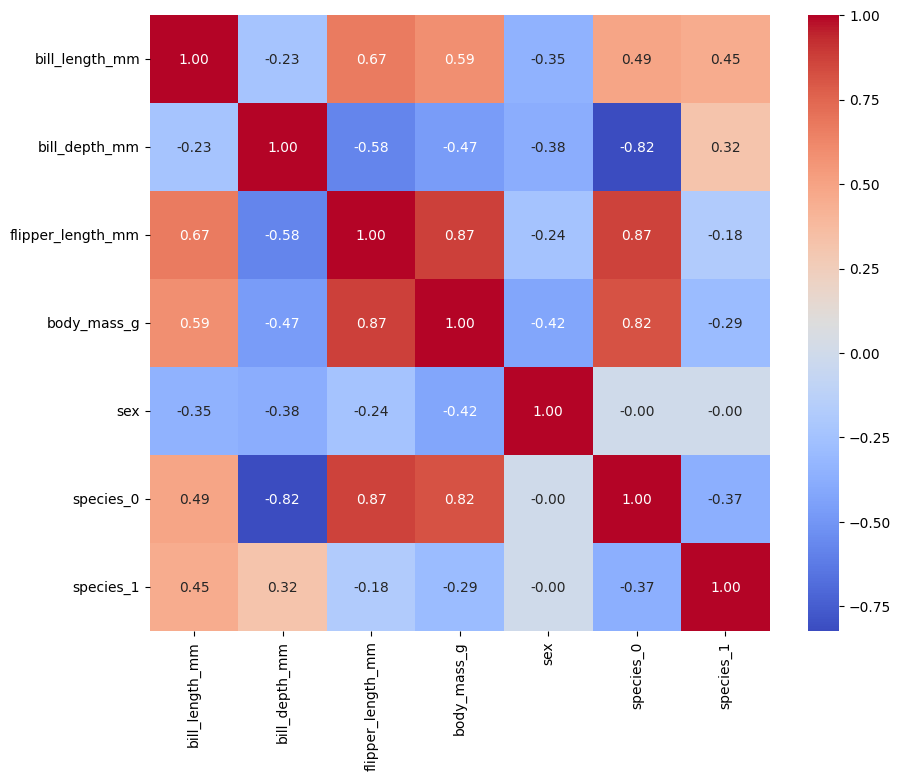

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.show()

Como podemos ver, ```species_0``` está correlada con otras tres variables (```bill_depth_mm```, ```flipper_length_mm``` y ```body_mass_g```). Esta variable (```species_0```) no me preocupa demasiado porque la voy a borrar igualmente después.

De las demás, ```flipper_length_mm``` y ```body_mass_g``` también están correladas, así que borraremos una de ellas (por ejemplo, ```flipper_length_mm```).

In [ ]:
df = df.drop(columns=["flipper_length_mm"])
df.head()

,bill_length_mm,bill_depth_mm,body_mass_g,sex,species_0,species_1
0,39.1,18.7,3750.0,0,0,0
1,39.5,17.4,3800.0,1,0,0
2,40.3,18.0,3250.0,1,0,0
4,36.7,19.3,3450.0,1,0,0
5,39.3,20.6,3650.0,0,0,0


## Aplicación de _KMeans_

Para usar _KMeans_, lo importo desde ```sklearn```.

In [ ]:
from sklearn.cluster import KMeans

random_seed = 33

Elimino la _feature_ por la que quiero agrupar.

In [ ]:
_df = df[df.columns[:-2]] # quiero hacer agrupaciones por la especie
_df

,bill_length_mm,bill_depth_mm,body_mass_g,sex
0,39.1,18.7,3750.0,0
1,39.5,17.4,3800.0,1
2,40.3,18.0,3250.0,1
4,36.7,19.3,3450.0,1
5,39.3,20.6,3650.0,0
...,...,...,...,...
338,47.2,13.7,4925.0,1
340,46.8,14.3,4850.0,1
341,50.4,15.7,5750.0,0
342,45.2,14.8,5200.0,1


Creo y entreno mi primer _KMeans_. La predicción del _KMeans_ es una lista de etiquetas (los grupos).

In [ ]:
model = KMeans(n_clusters=3, random_state=random_seed) # mi primer kmeans =)
pred = model.fit_predict(_df)
pred # pred contiene una etiqueta para cada valor

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,

Agrupación predicha para la especie según la masa y longitud del pico.

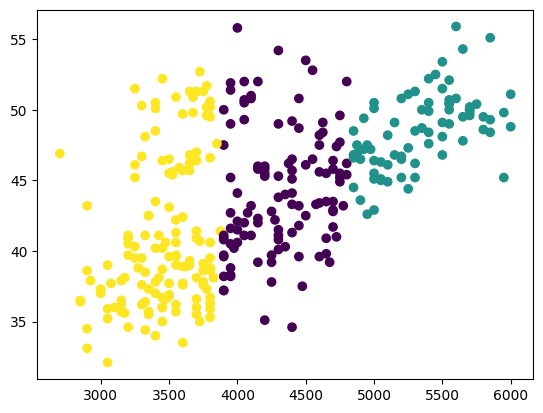

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=pred);

Agrupación real para la especie según la longitud y profundidad del pico.

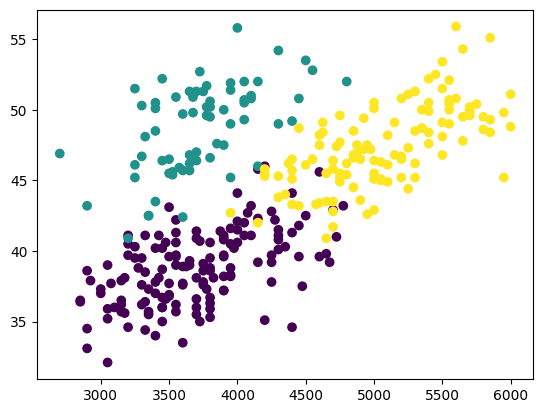

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=df["species_0"] * 2 + df["species_1"]); # son binarios

Esta versión inicial **NO** me sirve para este objetivo.

## Profundización

Habiendo visto los ejemplos inciales, vamos a ver los parámetros específicos para _KMeans_.

A la hora de crear el objeto _KMeans_, podemos establecer:
- ```n_clusters```: número de grupos a crear.
- ```init```: método de inicialización. Por defecto ```k-means++```.
- ```n_init```: número de veces que el algoritmo se ejecuta con distintas posiciones de los centroides. Se puede establecer en ```auto``` o darle un número a mano. Por defecto toma el valor ```10```.
- ```max_iter```: número máximo de iteraciones en el algoritmo. Por defecto ```300```.
- ```tol```: tolerancia relativa para determinar la convergencia (cuándo parar). Por defecto ```0.0001```.

## Optimización

Vamos a buscar una mejor solución a nuestro problema. Un algoritmo de _KMeans_ se suele optimizar modificando el hiperparámetro ```n_clusters```.

### 1ª idea: estandarizar el conjunto de datos

_KMeans_ es un modelo que trabaja con distancias. Estas distancias se calculan con pitágoras, por lo que tener muchas dimensiones o valores no estandarizados puede perjudicar al modelo. Mi primera idea para mejorar los resultados es estandarizar los datos.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()
_df = ss.fit_transform(_df) # como no tengo conjunto de testeo, no me preocupo en separar el fit del transform

Ahora entreno con los datos estandarizados

In [ ]:
model = KMeans(n_clusters=3, random_state=random_seed)
pred = model.fit_predict(_df)

Hago la misma prueba que antes.

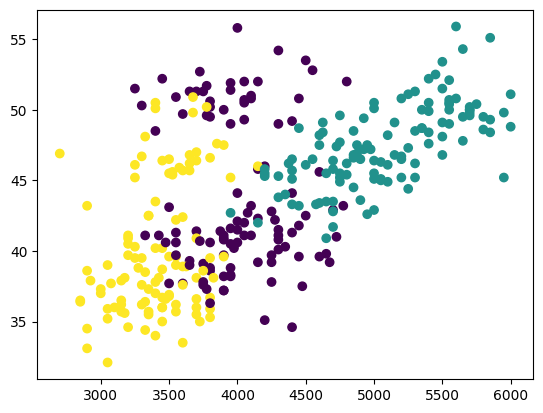

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=pred); # aunque estandarice, muestro los reales

Hemos mejorado un poco, pero tampoco es la realidad.

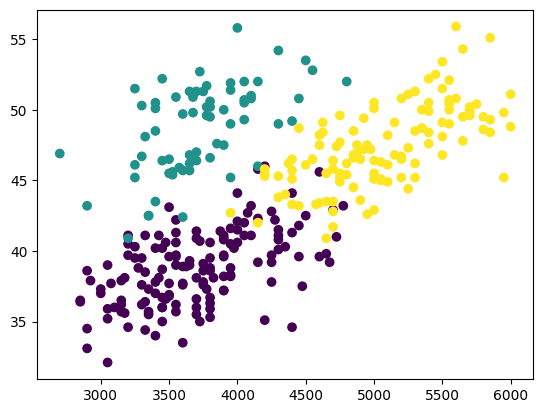

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=df["species_0"] * 2 + df["species_1"]); # son binarios

### 2ª idea: aumento el número de grupos

Otra idea que puede mejorar el resultado de _KMeans_ es el uso de varios grupos. Al usar más grupos de los necesarios, el algoritmo puede recoger particularidades más detalladas sobre cada uno de los grupos.

Probemos con 6 grupos.

Esta mejora es acumulativa: sigo con el conjunto estandarizado.

In [ ]:
model = KMeans(n_clusters=6, random_state=random_seed)
pred = model.fit_predict(_df)

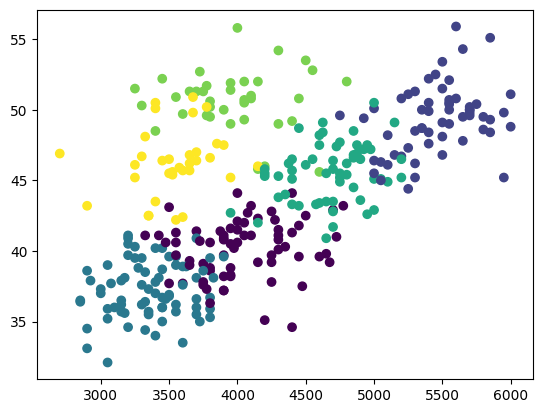

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=pred);

Como se puede ver, el resultado es muy parecido al real:
- La unión entre el morado oscuro y el azul oscuro reprenta a una de las especies.
- La unión entre amarillo y el verde claro representa otra especie.
- La unión entre verde oscuro y el otro color que queda (como se llame) es la última especie.

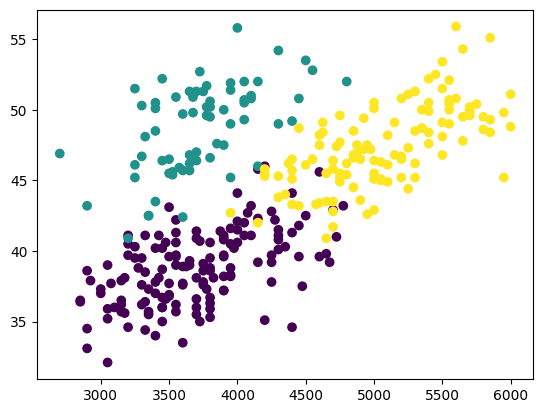

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=df["species_0"] * 2 + df["species_1"]);

Sin embargo, cualquiera puede preguntarme ahora _¿por qué has elegido el número 6 y no el 5 o el 7?_

### Automatizando el número de grupos: método del CODO

Con el algoritmo de _KMeans_ podemos ver la cantidad de información explicada por el algoritmo (en este caso, se llama inercia y se puede obtener desde el propio modelo, con el atributo ```inertia_```).

In [ ]:
model.inertia_

157.42015190709554

El método del CODO nos permite elegir el número de grupos que genera una mayor inercia: un cambio brusco en la aproximación de nuestros datos.

Estos cambios siempre irán de mayor (pocos grupos) a menor (muchos grupos). Nuestro objetivo es buscar el cambio brusco.

Para ello, tenemos que entrenar modelos usando 2, 3, ..., ```n_total``` grupos. Los casos extremos son el primero y el último: usar solo dos grupos o tantos grupos como instancias (¡cada punto será un grupo distinto!). Creemos una celda de código que nos permita aplicar este método.

Para poder comparar todos los modelos es **REQUISITO INDISPENSABLE** utilizar una misma semilla aleatoria.

In [ ]:
results = [] # donde voy a guardar las inercias

for n_clusters in range(2, len(_df) + 1):
  model = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_seed) # más importante que nunca
  model = model.fit(_df) # entreno
  results.append(model.inertia_) # guardo la inercia con esta cantidad de grupos

Muestro los resultados.

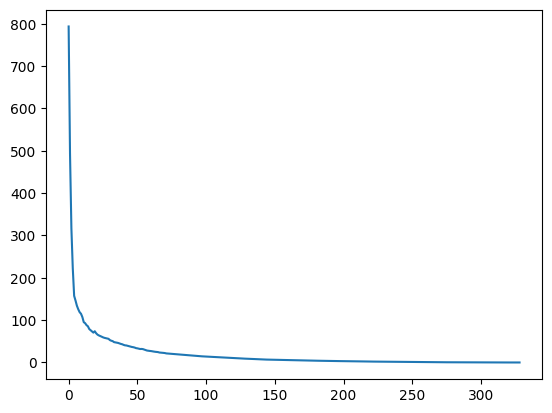

In [ ]:
plt.plot(results);

Para verlo mejor, _hago zoom_.

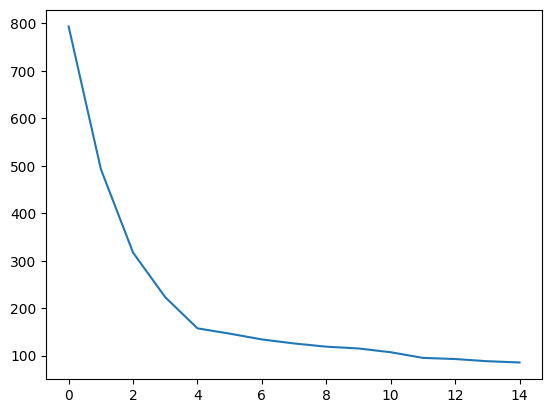

In [ ]:
plt.plot(results[:15]);

Como se puede ver, hay un cambio muy brusco en el 4. Así que la cantidad óptima de grupos estará después del 4 (mirar los dos siguientes valores). Uno es el 6 (que hemos visto que funciona bien), veamos el 5.

In [ ]:
model = KMeans(n_clusters=5, random_state=random_seed) # 5 por el método del CODO
pred = model.fit_predict(_df)

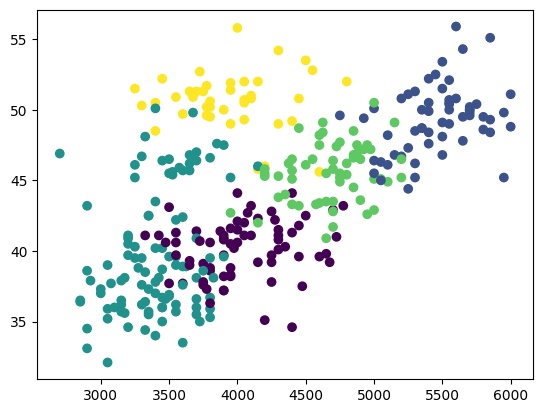

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=pred);

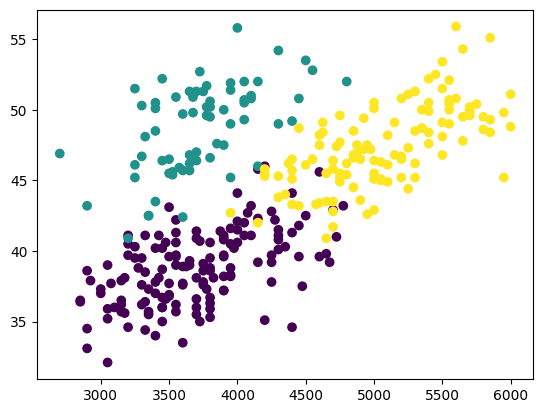

In [ ]:
plt.scatter(df.body_mass_g, df.bill_length_mm, c=df["species_0"] * 2 + df["species_1"]);

Habíamos acertado el 6 de chiripa. Vemos que el 5 se comporta peor.

# Resumen

El algoritmo _KMeans_ nos permite agrupar nuestro conjunto de datos sin asignar ninguna etiqueta preliminar. En este caso, hemos observado que la estandarización de los datos junto al uso de varios grupos es una técnica que funciona especialmente bien con este modelo.

En un problema real no dispondremos de valores para probar si estas estrategias funcionan o no, así que es buena idea hacer comprobaciones como las que hemos hecho en este conjunto de datos.